In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

import tensorflow as tf
from tensorflow.keras.initializers import he_normal, glorot_uniform
import tensorflow.keras.metrics as tkm
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from itertools import product
from tqdm import tqdm

SEED = 42

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(SEED)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

2025-04-22 17:18:35.158123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745353115.169576 1566159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745353115.173030 1566159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745353115.183889 1566159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745353115.183902 1566159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745353115.183904 1566159 computation_placer.cc:177] computation placer alr

In [2]:
# check GPUs
print("Available devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


2025-04-22 17:18:36.808799: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-22 17:18:36.808819: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-04-22 17:18:36.808824: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-04-22 17:18:36.808826: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-22 17:18:36.808830: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: insightlab-System-Product-Name
2025-04-22 17:18:36.808832: I external/local_xla/xla/str

## Reading Data

In [3]:
df = pd.read_csv('data/time_domain_features_holter_v2.csv')
y = df['died'].values.copy().reshape(-1, 1)
X = df.drop(['died', 'ID'], axis=1).values.copy()

# train-val-test split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
# val-test-split
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=SEED)

# train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

# standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X.shape

(176, 68)

In [4]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.ravel())
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train.ravel())
sample_weights

array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.5 , 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 1.5 , 0.75, 1.5 , 0.75, 0.75, 1.5 , 0.75, 0.75, 0.75,
       0.75, 0.75, 1.5 , 0.75, 1.5 , 0.75, 0.75, 1.5 , 0.75, 1.5 , 0.75,
       1.5 , 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       1.5 , 0.75, 0.75, 0.75, 0.75, 1.5 , 1.5 , 1.5 , 0.75, 0.75, 0.75,
       0.75, 0.75, 1.5 , 0.75, 1.5 , 0.75, 1.5 , 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 1.5 , 1.5 , 1.5 , 0.75, 0.75, 0.75, 1.5 , 0.75,
       1.5 , 1.5 , 1.5 , 0.75, 1.5 , 0.75, 0.75, 0.75, 1.5 , 0.75, 1.5 ,
       0.75, 1.5 , 0.75, 0.75, 0.75, 0.75, 1.5 , 0.75, 0.75, 1.5 , 0.75,
       1.5 , 0.75, 0.75, 1.5 , 0.75, 1.5 , 0.75, 1.5 , 0.75, 0.75, 1.5 ,
       1.5 , 1.5 , 1.5 , 1.5 , 0.75, 0.75, 0.75, 1.5 , 0.75, 1.5 , 1.5 ,
       0.75, 0.75])

In [6]:
param_grid = {
    'hidden_layers': [
        [16],
        [32],
        [64],
        [128],
        [256],
        [256, 128],
        [128, 64],
        [64, 32],
        [32, 16],
        [16, 8],
        [128, 64, 32],
        [64, 32, 16],
        [32, 16, 8],
    ],
    'dropout': [0., 0.3, 0.5],
    'batch_norm': [True, False],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [8, 16]
}
combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
print(f'Total combinations: {len(combinations)}')

Total combinations: 468


In [4]:
# Reduced param grid (just to see if it works)
param_grid = {
    'hidden_layers': [
        [16],
        [32],
    ],
    'dropout': [0., 0.3],
    'batch_norm': [True, False],
    'lr': [0.01, 0.001],
    'batch_size': [8, 16]
}
combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
print(f'Total combinations: {len(combinations)}')

Total combinations: 48


## Utils

In [5]:
def create_classifier(
    *,
    hidden_layers: list[int],
    input_size: int,
    dropout_rate: float,
    batch_norm: bool,
) -> Model:
    inputs = Input(shape=(input_size,))

    for hidden_units in hidden_layers:
        x = Dense(hidden_units, kernel_initializer='he_normal')(inputs)
        # x = Dense(hidden_units, kernel_initializer=he_normal(seed=SEED))(inputs)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    # outputs = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform())(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [6]:
class F1Score(tkm.Metric):
    def __init__(self, name="f1_score", threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # If one-hot encoded, convert to class indices
        if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
            y_true = tf.argmax(y_true, axis=-1)
            y_pred = tf.argmax(y_pred, axis=-1)
        else:
            y_pred = tf.cast(y_pred > self.threshold, tf.float32)

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        tp = tf.reduce_sum(tf.cast((y_true == 1) & (y_pred == 1), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), tf.float32))
        fn = tf.reduce_sum(tf.cast((y_true == 1) & (y_pred == 0), tf.float32))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [7]:
class Specificity(tkm.Metric):
    def __init__(self, name="specificity", threshold=0.5, **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tn = self.add_weight(name="tn", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # If one-hot encoded, convert to class indices
        if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
            y_true = tf.argmax(y_true, axis=-1)
            y_pred = tf.argmax(y_pred, axis=-1)
        else:
            y_pred = tf.cast(
                y_pred > self.threshold, tf.float32
            )  # Convert probabilities to binary values

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute TN and FP
        tn = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), tf.float32))

        self.tn.assign_add(tn)
        self.fp.assign_add(fp)

    def result(self):
        return self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tn.assign(0)
        self.fp.assign(0)

## Running model

In [13]:
with tf.device('/CPU:0'):
    early_stopping = EarlyStopping(
        monitor='val_f1_score',
        mode='max',
        patience=20,
        restore_best_weights=True
    )

    # creating model
    model = create_classifier(
        hidden_layers=[64],
        dropout_rate=0.3,
        batch_norm=False,
        input_size=X_train.shape[1]
    )

    # compiling
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tkm.Precision(name='precision'),
            tkm.Recall(name='recall'),
            tkm.AUC(name='auc'),
            F1Score(name='f1_score'),
            Specificity(name='specificity')
        ]
    )

    # training
    history = model.fit(X_train, y_train,
            epochs=200,
            batch_size=16,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            sample_weight=sample_weights,
    )

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3536 - auc: 0.4880 - f1_score: 0.5156 - loss: 1.3493 - precision: 0.3516 - recall: 0.9740 - specificity: 0.0122 - val_accuracy: 0.3462 - val_auc: 0.6863 - val_f1_score: 0.5143 - val_loss: 1.3140 - val_precision: 0.3462 - val_recall: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3776 - auc: 0.5730 - f1_score: 0.5041 - loss: 1.0591 - precision: 0.3513 - recall: 0.8973 - specificity: 0.0896 - val_accuracy: 0.3846 - val_auc: 0.6765 - val_f1_score: 0.5294 - val_loss: 1.1381 - val_precision: 0.3600 - val_recall: 1.0000 - val_specificity: 0.0588
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4021 - auc: 0.6349 - f1_score: 0.5000 - loss: 0.8701 - precision: 0.3558 - recall: 0.8462 - specificity: 0.1568 - val_accuracy: 0.3077 - val_auc: 0.6307 - val_f1_score: 0.4375 - val_loss: 1.0139 - val_precision: 0.3043 - val_recall: 0.7778 - val_specificity: 0.0588
Epoch 4/

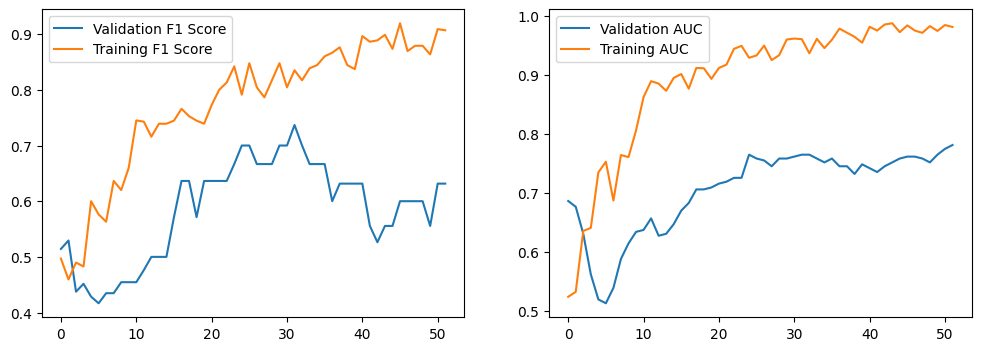

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['val_f1_score'], label='Validation F1 Score')
axes[0].plot(history.history['f1_score'], label='Training F1 Score')
axes[0].legend()
axes[1].plot(history.history['val_auc'], label='Validation AUC')
axes[1].plot(history.history['auc'], label='Training AUC')
axes[1].legend()
plt.show()

In [15]:
with tf.device('/CPU:0'):
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    specificity = tn / (tn + fp + 1e-08)

    print(f'AUC: {roc_auc_score(y_test, y_pred):.4f}')
    print(f'F1 score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Specificity: {specificity:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
AUC: 0.8704
F1 score: 0.7619
Precision: 0.6667
Recall: 0.8889
Specificity: 0.7778


## Running model with K-Fold CV

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
# X_test = holdout test set
# X_train = used to train-val in cross-validation

In [17]:
from sklearn.model_selection import StratifiedKFold

# K-Fold setup
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

with tf.device('/CPU:0'):
    # To track best model
    metric_to_track = 'val_f1_score'
    best_avg_metric = -np.inf
    best_std_metric = np.inf
    best_config = None
    best_model_weights = None

    # Start hyperparameter search
    for combo in tqdm(combinations, desc="Combination"):
        params = dict(zip(param_names, combo))
        fold_metrics = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            # Split data
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Standardization
            scaler = StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)

            # Build model
            model = create_classifier(
                hidden_layers=params['hidden_layers'],
                dropout_rate=params['dropout'],
                batch_norm=params['batch_norm'],
                input_size=X.shape[1]
            )

            model.compile(
                optimizer=Adam(learning_rate=params['lr']),
                loss='binary_crossentropy',
                metrics=[
                    'accuracy',
                    tkm.Precision(name='precision'),
                    tkm.Recall(name='recall'),
                    tkm.AUC(name='auc'),
                    F1Score(name='f1_score'),
                    Specificity(name='specificity')
                ]
            )

            # Early stopping
            early_stop = EarlyStopping(
                monitor=metric_to_track,
                mode='max',
                patience=20,
                restore_best_weights=True,
                verbose=0
            )

            # Train
            model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=200,
                batch_size=params['batch_size'],
                callbacks=[early_stop],
                verbose=0,
                sample_weight=compute_sample_weight(class_weight='balanced', y=y_train_fold.ravel())
            )

            # Predict on validation set
            y_pred_val = model.predict(X_val_fold, verbose=0)
            y_pred_labels = (y_pred_val > 0.5).astype(int)

            # Metric calculation
            if metric_to_track == 'val_f1_score':
                f1 = f1_score(y_val_fold, y_pred_labels)
                fold_metrics.append(f1)
            elif metric_to_track == 'val_auc':
                auc = roc_auc_score(y_val_fold, y_pred_val)
                fold_metrics.append(auc)

        # Mean Metric across folds
        avg_metric = np.mean(fold_metrics)
        std_metric = np.std(fold_metrics)

        # Track best
        if avg_metric > best_avg_metric:
            best_avg_metric = avg_metric
            best_std_metric = std_metric
            best_config = params
            best_model_weights = model.get_weights()  # Save best model

            tqdm.write(f"Saving model with best {metric_to_track} = {avg_metric:.4f} +- {std_metric:.4f}")

Combination:   0%|          | 0/468 [00:00<?, ?it/s]

Combination:   0%|          | 1/468 [00:13<1:42:46, 13.20s/it]

Saving model with best val_f1_score = 0.7165 +- 0.0791


Combination:   0%|          | 2/468 [00:26<1:41:58, 13.13s/it]

Saving model with best val_f1_score = 0.7325 +- 0.0648


Combination:   3%|▎         | 13/468 [03:03<1:46:14, 14.01s/it]

Saving model with best val_f1_score = 0.7655 +- 0.0870


Combination:   5%|▌         | 25/468 [06:04<1:46:10, 14.38s/it]

Saving model with best val_f1_score = 0.7686 +- 0.0450


Combination:  13%|█▎        | 62/468 [14:53<1:40:18, 14.82s/it]

Saving model with best val_f1_score = 0.7739 +- 0.0522


Combination:  21%|██        | 97/468 [23:26<1:30:30, 14.64s/it]

Saving model with best val_f1_score = 0.7769 +- 0.0791


Combination:  52%|█████▏    | 242/468 [58:57<58:45, 15.60s/it]  

Saving model with best val_f1_score = 0.7931 +- 0.0492


Combination:  87%|████████▋ | 409/468 [1:41:39<14:51, 15.11s/it]  

Saving model with best val_f1_score = 0.7951 +- 0.0534


Combination:  95%|█████████▌| 446/468 [1:50:34<05:58, 16.29s/it]

Saving model with best val_f1_score = 0.8025 +- 0.0607


Combination:  98%|█████████▊| 458/468 [1:54:47<03:14, 19.48s/it]

Saving model with best val_f1_score = 0.8029 +- 0.0388


Combination: 100%|██████████| 468/468 [1:57:50<00:00, 15.11s/it]


In [18]:
# Summary
print("Best Config:", best_config)
print(f"Best Score: {best_avg_metric:.4f} +- {best_std_metric:.4f}")

Best Config: {'hidden_layers': [32, 16, 8], 'dropout': 0.5, 'batch_norm': True, 'lr': 0.01, 'batch_size': 16}
Best Score: 0.8029 +- 0.0388


In [19]:
# training and then testing on holdout set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build model
model = create_classifier(
    hidden_layers=best_config['hidden_layers'],
    dropout_rate=best_config['dropout'],
    batch_norm=best_config['batch_norm'],
    input_size=X.shape[1]
)

model.set_weights(best_model_weights)

In [20]:
# Predict on test set
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
specificity = tn / (tn + fp + 1e-08)

print(f'AUC: {roc_auc_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred_binary):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_binary):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_binary):.4f}')
print(f'Specificity: {specificity:.4f}')

AUC: 0.8190
F1 score: 0.6341
Precision: 0.5652
Recall: 0.7222
Specificity: 0.7143


In [25]:
# training and then testing on holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build model
model = create_classifier(
    hidden_layers=best_config['hidden_layers'],
    dropout_rate=best_config['dropout'],
    batch_norm=best_config['batch_norm'],
    input_size=X.shape[1]
)

model.compile(
    optimizer=Adam(learning_rate=best_config['lr']),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tkm.Precision(name='precision'),
        tkm.Recall(name='recall'),
        tkm.AUC(name='auc'),
        F1Score(name='f1_score'),
        Specificity(name='specificity')
    ]
)

# Early stopping
early_stop = EarlyStopping(
    monitor=metric_to_track,
    mode='max',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

# Train
model.fit(
    X_train, y_train,
    validation_split=0.,
    epochs=200,
    batch_size=best_config['batch_size'],
    callbacks=[early_stop],
    verbose=0,
    sample_weight=compute_sample_weight(class_weight='balanced', y=y_train.ravel())
)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,auc,f1_score,loss,precision,recall,specificity
  current = self.get_monitor_value(logs)


In [10]:
# training and then testing on holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Best Config: {'hidden_layers': [32, 16, 8], 'dropout': 0.5, 'batch_norm': True, 'lr': 0.01, 'batch_size': 16}
# Build model
model = create_classifier(
    hidden_layers=[32, 16, 8],
    dropout_rate=0.5,
    batch_norm=True,
    input_size=X.shape[1]
)

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tkm.Precision(name='precision'),
        tkm.Recall(name='recall'),
        tkm.AUC(name='auc'),
        F1Score(name='f1_score'),
        Specificity(name='specificity')
    ]
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

# Train
model.fit(
    X_train, y_train,
    validation_split=0.,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0,
    sample_weight=compute_sample_weight(class_weight='balanced', y=y_train.ravel())
)

/home/kelvin/Downloads/scd-feature-reduction/.venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,auc,f1_score,loss,precision,recall,specificity
  current = self.get_monitor_value(logs)


In [11]:
# Predict on test set
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
specificity = tn / (tn + fp + 1e-08)

print(f'AUC: {roc_auc_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred_binary):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_binary):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_binary):.4f}')
print(f'Specificity: {specificity:.4f}')

AUC: 0.8905
F1 score: 0.7692
Precision: 0.7143
Recall: 0.8333
Specificity: 0.8286
